In [1]:
import matplotlib.pyplot as plt
import skimage
from skimage.io import imread
import numpy as np
from pathlib import Path

In [2]:
def image_combination(over, under):
    over = over/255
    under = under/255
    over = skimage.color.rgb2ycbcr(over)
    under = skimage.color.rgb2ycbcr(under)
    #overexposed
    Yfilt = skimage.restoration.denoise_bilateral(over[:,:,0], sigma_spatial=3)
    Yover = over[:,:,0] - Yfilt
    #underexposed
    Yunder = skimage.restoration.denoise_bilateral(under[:,:,0], sigma_spatial=3)
    #combine
    x = len(over[:,1])
    y = len(over[1,:])
    final = np.empty((x,y,3))
    final[:,:,0] = Yover + Yunder
    final[:,:,1] = over[:,:,1]
    final[:,:,2] = over[:,:,2]
    final_image = skimage.color.ycbcr2rgb(final)
    return final_image

In [3]:
def local_gamma(im):
    im =im/255
    ycbcr = skimage.color.rgb2ycbcr(im)
    y = ycbcr[:,:,0]
    y_filt = skimage.restoration.denoise_bilateral(y, sigma_spatial=5)
    mask = 255-y_filt
    row = np.size(y[:,1])
    col = np.size(y[1,:])
    Y_final = np.empty((row, col))
    for i in range(row):
        for j in range(col):
            exp2 = (128-mask[i,j])/128
            exp = 2**exp2
            value=(y[i,j]/255)**exp
            output=255*value
            Y_final[i,j]= output
    ycbcr[:,:,0] = Y_final
    final = skimage.color.ycbcr2rgb(ycbcr)
    return final

In [10]:
from mtcnn.mtcnn import MTCNN
detector = MTCNN()


In [ ]:
from tqdm import tqdm
path = "../../../dataset/train/"

train_images_path = list(Path(path).rglob(f"*.jpg"))
values = []
for path in tqdm(train_images_path):
    im = imread(path)
    v = np.sum(im<128) / np.sum(im>128)
    values += [v]
values.sort()

 43%|████▎     | 4781/11220 [00:12<00:16, 379.97it/s]


KeyboardInterrupt: 

In [53]:
def preprocess_all(img):
    ycbcr = skimage.color.rgb2ycbcr(im)
    ycbcr = ycbcr/255
    y = ycbcr[:,:,0]
    value = np.sum(y<0.5) / np.sum(y>0.5)
    if value > 5 or value == "inf":
        y = skimage.exposure.adjust_gamma(y, 0.7)
    elif value < 0.2:
        y = skimage.exposure.adjust_gamma(y, 1.3)
    ycbcr[:,:,0] = y
    final = skimage.color.ycbcr2rgb(ycbcr*255)
    final = skimage.filters.unsharp_mask(final, radius=2, amount=1)
    final = np.clip(final, 0,1)*255
    return final

In [125]:
def process_crop(im):
    im = (im - np.min(im)) / (np.max(im) - np.min(im))
    ycbcr = skimage.color.rgb2ycbcr(im)
    ycbcr = ycbcr/255
    y = ycbcr[:,:,0]
    sharp= False
    value = np.sum(y<0.5) / np.sum(y>0.5)
    if value > 5 or value == "inf" or value < 0.2:
        sharp = True
    while True:
        value = np.sum(y<0.5) / np.sum(y>0.5)
        if value > 5 or value == "inf":
            y = skimage.exposure.adjust_gamma(y, 0.8)
        elif value < 0.2:
            print(value)
            y = skimage.exposure.adjust_gamma(y, 1.2)
        else:
            break
    ycbcr[:,:,0] = y
    final = skimage.color.ycbcr2rgb(ycbcr*255)
    final = np.clip(final, 0,1)
    # enhanced image = original + amount * (original - blurred)
    if sharp:
        final = skimage.filters.unsharp_mask(final, radius=2, amount=1)
    else:
        final = skimage.filters.unsharp_mask(final, radius=1, amount=0.5)

    return final

In [126]:
def try_rotate(img):
    faces = []
    im = []
    for i in range(0, 360, 90):
        im = skimage.transform.rotate(img, i, resize=True)*255
        print("rotate "+ str(i))
        im = np.clip(im, 0,255)
        faces = detector.detect_faces(im)
        if len(faces)>0:
            break
    return faces, im, i

In [127]:
def find_face_and_preprocess(path):
    final_imgs = []
    im = imread(path)
    crops = []
    faces = detector.detect_faces(im)
    print("QUA 1")
    if len(faces)==0:
        #im = preprocess_all(im)
        print("QUA 2")
        faces = detector.detect_faces(im)
        print("QUA 3")
        if len(faces)==0:
            print("QUA 4")
            faces, im, _ = try_rotate(im)
            print("QUA 5")
            print(len(faces))
            if len(faces) == 0:
                print("no faces")
                return None
    for face in faces:
        print("QUA 6")
        [X,Y,W,H] = face['box']
        crop = im[Y:Y+H, X:X+W]
        face = detector.detect_faces(crop)
        print("QUA 7")
        print(len(face))
        if len(face) == 0:
            print("QUA 8")
            face, crop, rotation = try_rotate(crop)
            im = skimage.transform.rotate(im, rotation, resize=True)
            face = detector.detect_faces(im*255)
            [X,Y,W,H] = face[0]['box']
        print(len(face))
        if len(face) == 1:
            base = len(im[:,1,1])
            h = len(im[1,:,1])
            bord_x = 30
            bord_y = 70
            crop = im[Y:Y+H, X:X+W]
            if (Y-bord_y > 0) and (Y+H+bord_y < h) and (X-bord_x > 0) and (X+W+bord_x < base):
                crops += [im[Y-bord_y:Y+H+bord_y, X-bord_x:X+W+bord_x]]
            else:
                crops += [im[Y:Y+H, X:X+W]]
    if len(crops) == 0:
        print("no faces")
        return None
    else:
        for crop in crops:
            print("QUA 11")
            final_crop = process_crop(crop)
            final_imgs += [final_crop]
    return final_imgs


4/4 [==============================] - 0s 2ms/step
QUA 1
QUA 2
4/4 [==============================] - 0s 3ms/step
QUA 3
QUA 4
rotate 0
4/4 [==============================] - 0s 3ms/step
rotate 90
3/3 [==============================] - 0s 2ms/step
rotate 180
3/3 [==============================] - 0s 3ms/step
rotate 270
1/1 [==============================] - 0s 10ms/step
QUA 5
4
QUA 6
1/1 [==============================] - 0s 9ms/step
QUA 7
1
1
QUA 6
1/1 [==============================] - 0s 9ms/step
QUA 7
1
1
QUA 6
1/1 [==============================] - 0s 10ms/step
QUA 7
1
1
QUA 6
1/1 [==============================] - 0s 10ms/step
QUA 7
1
1
QUA 11
QUA 11
QUA 11
QUA 11


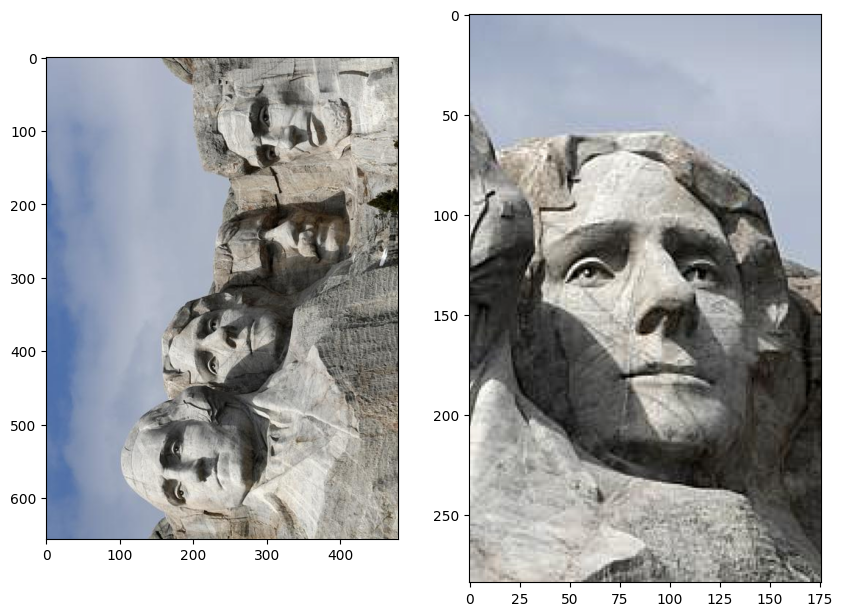

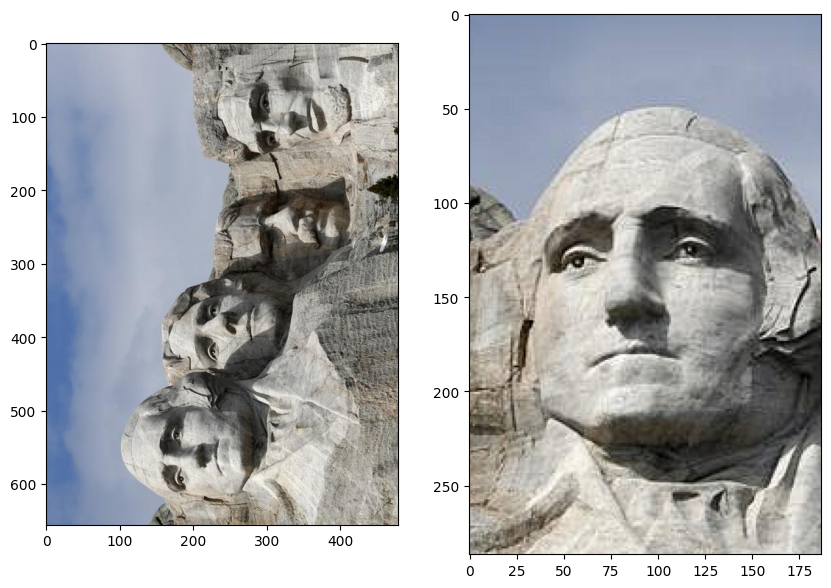

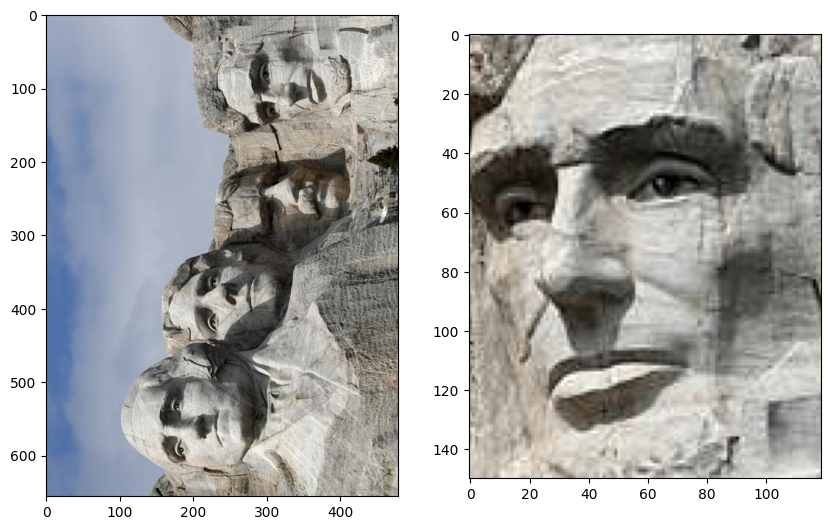

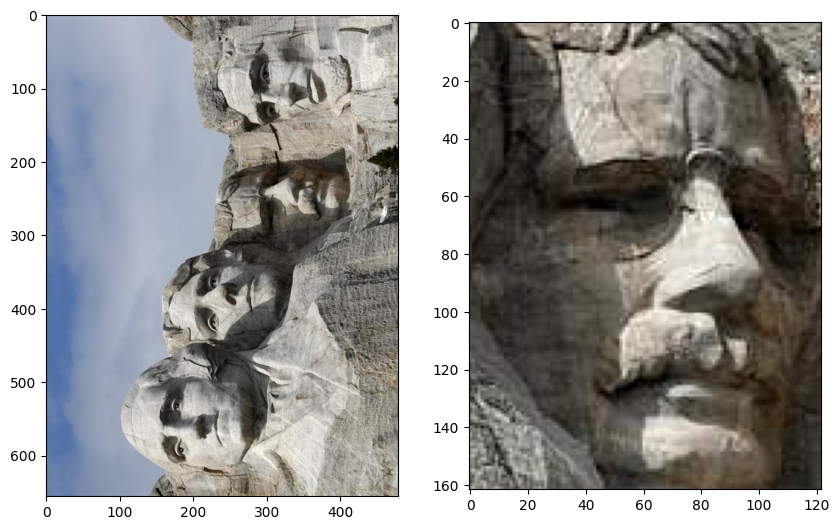

In [146]:
path = "./imgs/mount.jpg"
final_crop = find_face_and_preprocess(path)
if final_crop is not None:
    for i in final_crop:
        plt.figure(figsize=(10,10))
        plt.subplot(1,2,1)
        plt.imshow(imread(path))
        plt.subplot(1,2,2)
        plt.imshow(i)

In [139]:
a = final_crop[0]*255
#a = skimage.transform.rotate(a, 270)
face = detector.detect_faces(a)
face

1/1 [==============================] - 0s 10ms/step


[{'box': [14, 37, 388, 450],
  'confidence': 0.9756684303283691,
  'keypoints': {'left_eye': (138, 219),
   'right_eye': (285, 217),
   'nose': (206, 322),
   'mouth_left': (145, 379),
   'mouth_right': (267, 380)}}]